In [66]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!pip install japanize_matplotlib
import japanize_matplotlib 
import lightgbm as lgb
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

In [68]:
input_path = '/content/drive/MyDrive/input/ai_quest_pbl01/'

In [69]:
submission_4th_df = pd.read_csv(input_path + '4th.csv', names = ['index', 'pred'])
answer_df = pd.read_csv(input_path + 'answer.csv', names = ['index', 'real'])
test_df= pd.read_csv(input_path + 'test.csv')
category_df= pd.read_csv(input_path + 'category_names.csv')
item_categories_df= pd.read_csv(input_path + 'item_categories.csv')
sales_history = pd.read_csv(input_path + "sales_history.csv")

In [70]:
print(submission_4th_df.shape)
print(answer_df.shape)
print(test_df.shape)
display(test_df.head())
display(category_df.head())
display(item_categories_df.head())

(3060, 2)
(3060, 2)
(3060, 3)


,index,商品ID,店舗ID
0,0,1000001,0
1,1,1000001,1
2,2,1000001,2
3,3,1000001,3
4,4,1000001,4


,商品カテゴリID,商品カテゴリ名
0,100,映画 - DVD
1,110,PCゲーム - 通常版
2,120,音楽 - その他
3,130,ゲーム - ゲーム機C
4,140,映画 - ブルーレイ


,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100


In [71]:
submission_4th_df['real'] = answer_df['real']
submission_4th_df['diff'] = submission_4th_df['real'] - submission_4th_df['pred']
submission_4th_df['商品ID'] = test_df['商品ID']
submission_4th_df['店舗ID'] = test_df['店舗ID']

print(submission_4th_df.shape)

analysis_df = pd.merge(
  submission_4th_df,
  item_categories_df,
  on = '商品ID',
  how = 'left'
)

analysis_df = pd.merge(
  analysis_df,
  category_df,
  on = '商品カテゴリID',
  how = 'left'
)
analysis_df['diff_abs'] = abs(analysis_df['diff'])
print(analysis_df.shape)
display(analysis_df.head())

(3060, 6)
(3060, 9)


,index,pred,real,diff,商品ID,店舗ID,商品カテゴリID,商品カテゴリ名,diff_abs
0,0,2,0.0,-2.0,1000001,0,100,映画 - DVD,2.0
1,1,1,0.0,-1.0,1000001,1,100,映画 - DVD,1.0
2,2,1,0.0,-1.0,1000001,2,100,映画 - DVD,1.0
3,3,4,3.0,-1.0,1000001,3,100,映画 - DVD,1.0
4,4,3,7.0,4.0,1000001,4,100,映画 - DVD,4.0


In [72]:
new_items = [
  1400898, 
  3200026, 
  1002291, 
  2000162, 
  1600052, 
  1600054, 
  1800179,
  2500229, 
  2500230, 
  1002377, 
  2100152, 
  2400088, 
  1201269, 
  1201262,
  2800090, 
  2800101, 
  2800103, 
  1002503, 
  2900075, 
  1002582
]

old_items = list(set(analysis_df['商品ID']) - set(new_items))

new_items_df = analysis_df[analysis_df['商品ID'].isin(new_items)]
old_items_df = analysis_df[analysis_df['商品ID'].isin(old_items)]
display(new_items_df.head())
display(old_items_df.head())

,index,pred,real,diff,商品ID,店舗ID,商品カテゴリID,商品カテゴリ名,diff_abs
198,198,3,1.0,-2.0,1002291,0,100,映画 - DVD,2.0
199,199,2,0.0,-2.0,1002291,1,100,映画 - DVD,2.0
200,200,2,0.0,-2.0,1002291,2,100,映画 - DVD,2.0
201,201,3,0.0,-3.0,1002291,3,100,映画 - DVD,3.0
202,202,3,0.0,-3.0,1002291,4,100,映画 - DVD,3.0


,index,pred,real,diff,商品ID,店舗ID,商品カテゴリID,商品カテゴリ名,diff_abs
0,0,2,0.0,-2.0,1000001,0,100,映画 - DVD,2.0
1,1,1,0.0,-1.0,1000001,1,100,映画 - DVD,1.0
2,2,1,0.0,-1.0,1000001,2,100,映画 - DVD,1.0
3,3,4,3.0,-1.0,1000001,3,100,映画 - DVD,1.0
4,4,3,7.0,4.0,1000001,4,100,映画 - DVD,4.0


# RMSE計算

In [73]:
rmse_dict = {
  'カテゴリ名':[],
  '商品数':[],
  'RMSE':[]
}
category_list = sorted(analysis_df['商品カテゴリ名'].unique())

rmse = np.sqrt(mse(analysis_df['real'], analysis_df['pred']))
print('all')
print('rmse', rmse)
print()
print('*'*50)

rmse_dict['カテゴリ名'].append('全カテゴリ')
rmse_dict['商品数'].append(len(analysis_df))
rmse_dict['RMSE'].append(rmse)

for category_nm in category_list:
  tmp_df = analysis_df[analysis_df['商品カテゴリ名'] == category_nm]
  rmse = np.sqrt(mse(tmp_df['real'], tmp_df['pred']))
  print(category_nm)
  print(tmp_df.shape)
  print('rmse', rmse)
  print()
  print('*'*50)

  rmse_dict['カテゴリ名'].append(category_nm)
  rmse_dict['商品数'].append(len(tmp_df))
  rmse_dict['RMSE'].append(rmse)

rmse_df = pd.DataFrame(rmse_dict)
display(rmse_df.head(100))


all
rmse 2.405671403571316

**************************************************
PCゲーム - 通常版
(36, 9)
rmse 5.30461015427985

**************************************************
PCソフト - PCソフト
(36, 9)
rmse 0.9860132971832694

**************************************************
ギフト - ぬいぐるみ
(126, 9)
rmse 1.7950549357115013

**************************************************
ギフト - カード、パズル等
(342, 9)
rmse 1.2875926129184283

**************************************************
ギフト - ガジェット類
(108, 9)
rmse 1.3505828645714688

**************************************************
ギフト - フィギュア
(90, 9)
rmse 1.8287822299126937

**************************************************
ギフト - ボードゲーム
(270, 9)
rmse 2.0367003088692623

**************************************************
ギフト - 小型ゲーム
(90, 9)
rmse 6.238767684585011

**************************************************
ギフト - 記念品_タイプA
(72, 9)
rmse 6.077051551168178

**************************************************
ギフト - 記念品_タイプB
(72, 9)
rmse 7.721722605740251



,カテゴリ名,商品数,RMSE
0,全カテゴリ,3060,2.405671
1,PCゲーム - 通常版,36,5.304610
2,PCソフト - PCソフト,36,0.986013
3,ギフト - ぬいぐるみ,126,1.795055
4,ギフト - カード、パズル等,342,1.287593
5,ギフト - ガジェット類,108,1.350583
6,ギフト - フィギュア,90,1.828782
7,ギフト - ボードゲーム,270,2.036700
8,ギフト - 小型ゲーム,90,6.238768
9,ギフト - 記念品_タイプA,72,6.077052


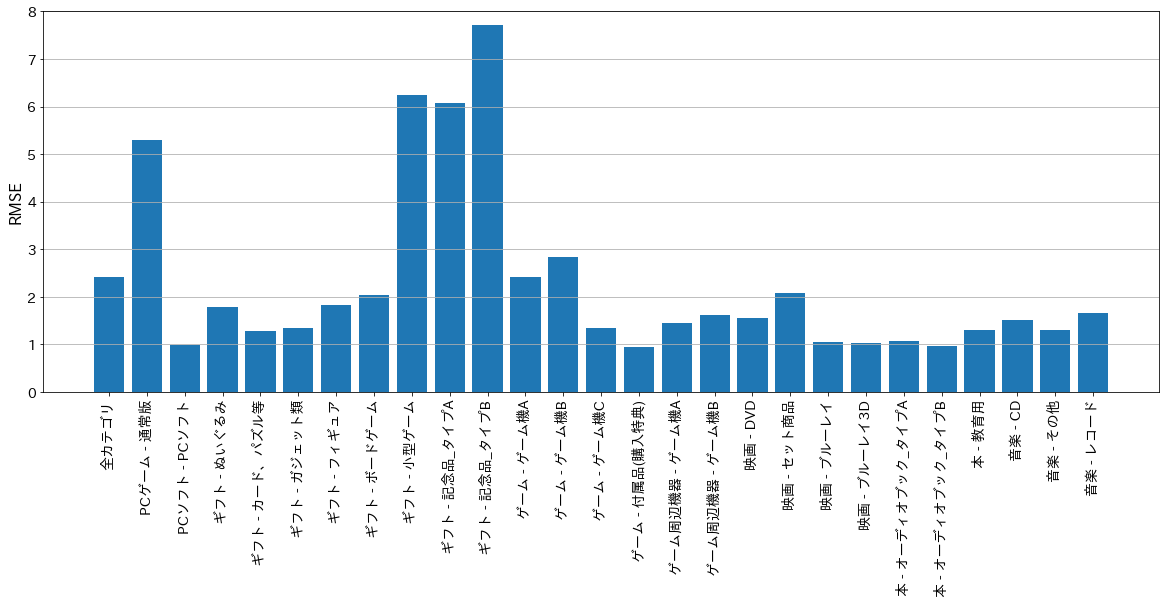

27


In [74]:
plt.figure(figsize = (20, 7))
plt.bar(rmse_df['カテゴリ名'], rmse_df['RMSE'])
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14)
plt.ylabel('RMSE', fontsize = 16)
plt.ylim(0, 8)
plt.grid(axis = 'y')
plt.show()

print(len(rmse_df))

# 予実誤差確認

In [75]:
print('diff_abs')
print('all', analysis_df['diff_abs'].sum()/18)
print('new', new_items_df['diff_abs'].sum()/18)
print('old', old_items_df['diff_abs'].sum()/18)

print()

print('個数実績')
print(analysis_df['real'].sum()/18)
print(new_items_df['real'].sum()/18)
print(old_items_df['real'].sum()/18)

print()

print('sales_num')
print('all', analysis_df['diff_abs'].sum() / analysis_df['real'].sum())
print('new', new_items_df['diff_abs'].sum()/ new_items_df['real'].sum())
print('old', old_items_df['diff_abs'].sum() / old_items_df['real'].sum())

diff_abs
all 222.05555555555554
new 46.05555555555556
old 176.0

個数実績
284.94444444444446
74.66666666666667
210.27777777777777

sales_num
all 0.7792942093975433
new 0.6168154761904762
old 0.8369881109643329


# 予実グラフ

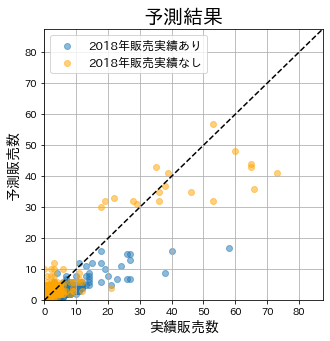

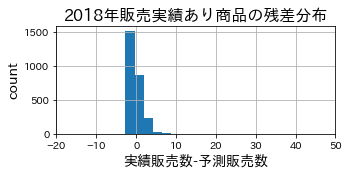

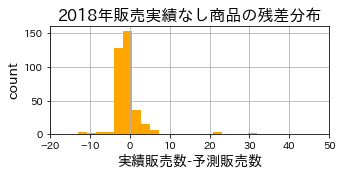

In [76]:
plt.figure(figsize = (5, 5), facecolor = 'white')
plt.scatter(old_items_df['real'], old_items_df['pred'], alpha = 0.5, label = '2018年販売実績あり')
plt.scatter(new_items_df['real'], new_items_df['pred'], color= 'orange', alpha = 0.5, label = '2018年販売実績なし')
plt.plot([0, 100], [0, 100], color = 'black', linestyle = '--')
plt.xlim(0, submission_4th_df['real'].max()*1.2)
plt.ylim(0, submission_4th_df['real'].max()*1.2)
plt.xlabel('実績販売数', fontsize = 14)
plt.ylabel('予測販売数', fontsize =14)
plt.title('予測結果', fontsize = 20)
plt.grid()
plt.legend(fontsize = 12)
plt.show()

print()
print()

plt.figure(figsize = (5, 2), facecolor = 'white')
old_items_df['diff'].hist(bins = 20)
plt.title('2018年販売実績あり商品の残差分布', fontsize= 16)
plt.xlabel('実績販売数-予測販売数', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.xlim(-20, 50)
plt.show()

print()
print()

plt.figure(figsize = (5, 2), facecolor = 'white')
new_items_df['diff'].hist(bins = 20, color = 'orange')
plt.title('2018年販売実績なし商品の残差分布', fontsize= 16)
plt.xlabel('実績販売数-予測販売数', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.xlim(-20, 50)
plt.show()

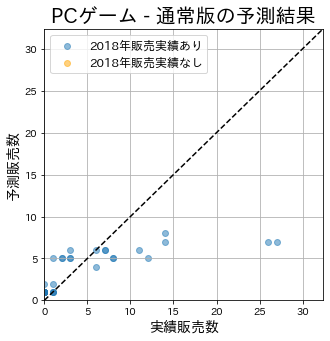

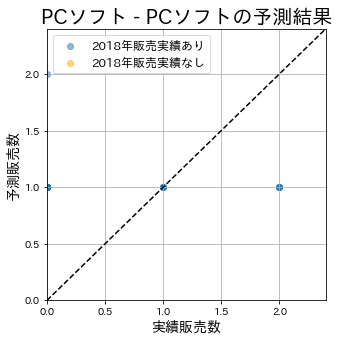

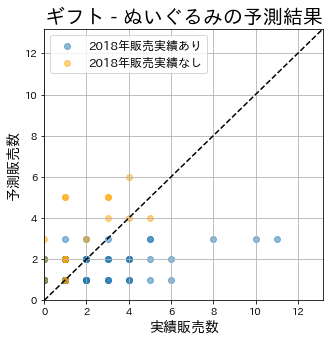

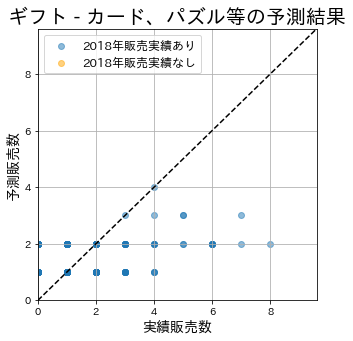

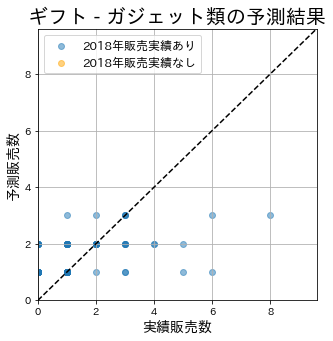

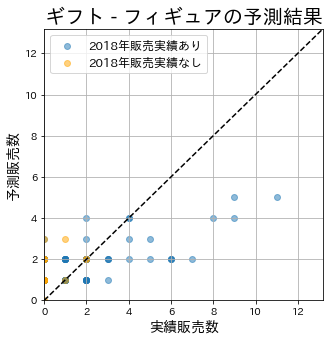

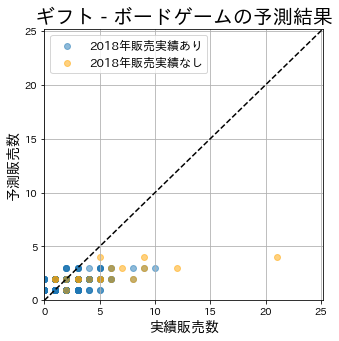

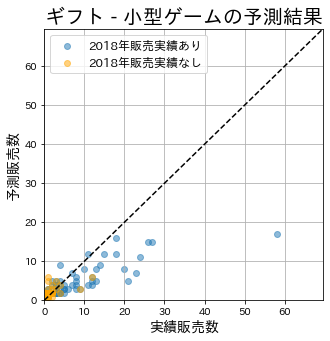

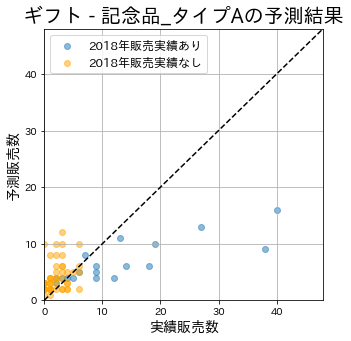

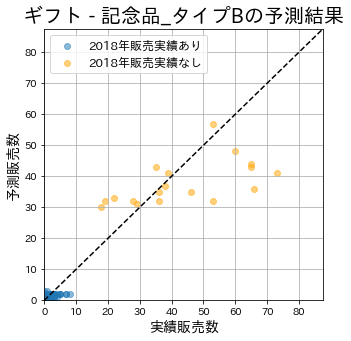

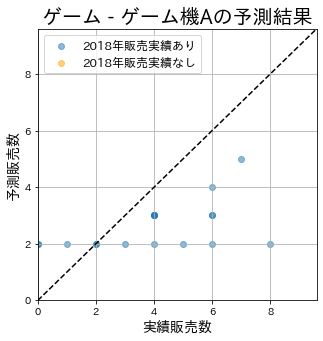

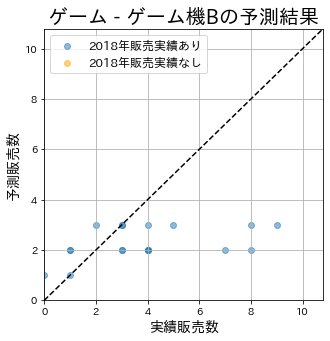

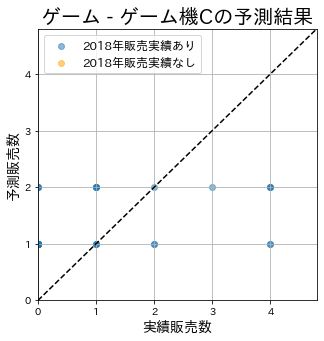

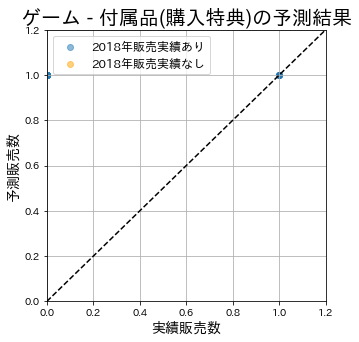

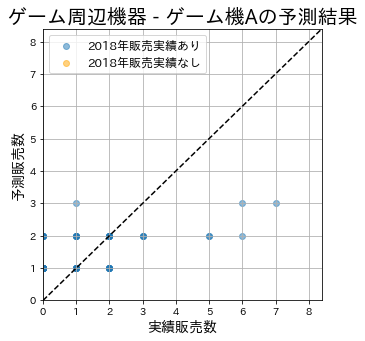

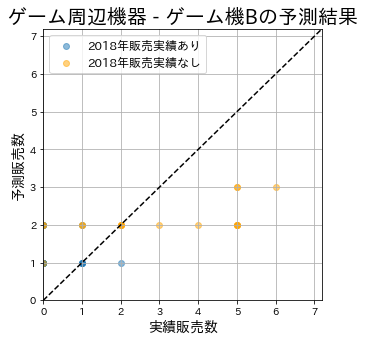

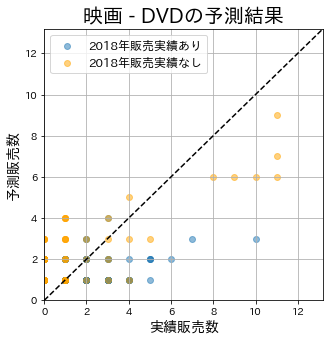

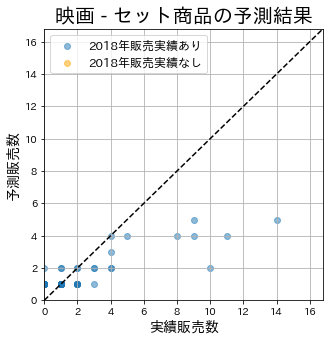

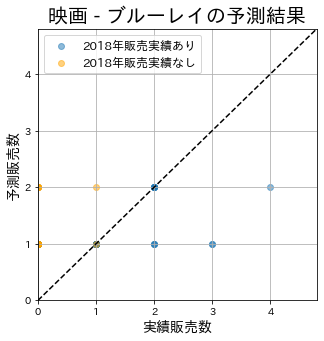

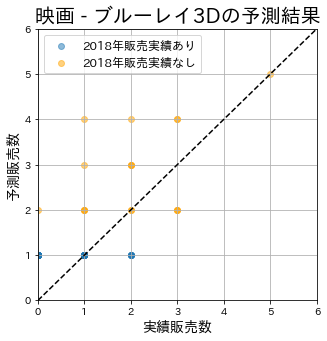

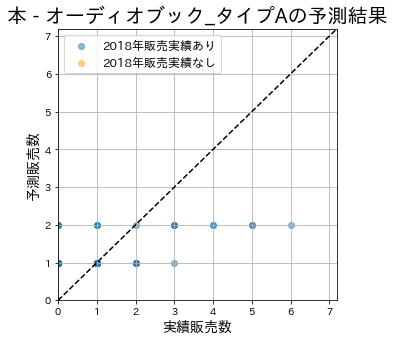

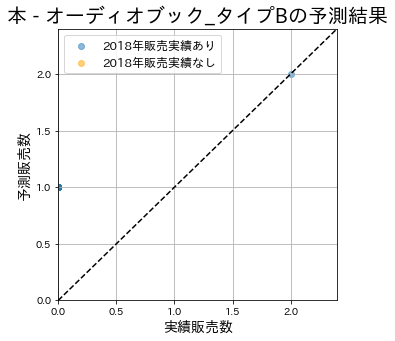

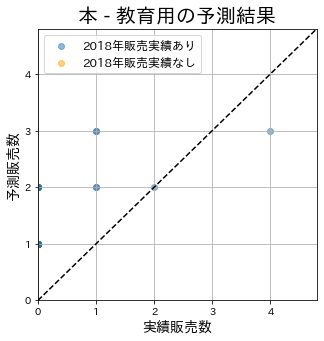

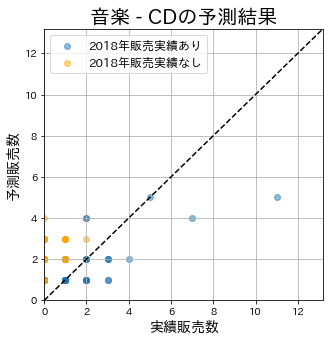

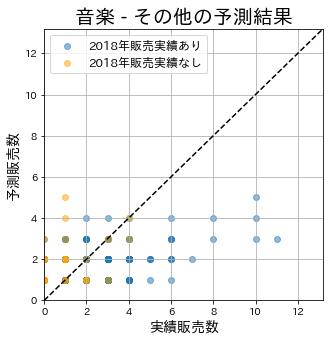

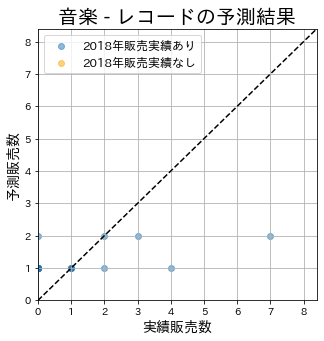

In [77]:
category_list = sorted(analysis_df['商品カテゴリ名'].unique())
for category_nm in category_list:
  tmp_old_df = old_items_df[old_items_df['商品カテゴリ名'] == category_nm]
  tmp_new_df = new_items_df[new_items_df['商品カテゴリ名'] == category_nm]


  plt.figure(figsize = (5, 5), facecolor = 'white')
  plt.scatter(tmp_old_df['real'], tmp_old_df['pred'], alpha = 0.5, label = '2018年販売実績あり')
  plt.scatter(tmp_new_df['real'], tmp_new_df['pred'], color= 'orange', alpha = 0.5, label = '2018年販売実績なし')
  plt.plot([0, 100], [0, 100], color = 'black', linestyle = '--')
  plt.xlim(0, max(tmp_old_df['real'].max(), tmp_new_df['real'].max())*1.2)
  plt.ylim(0,max(tmp_old_df['real'].max(), tmp_new_df['real'].max())*1.2)
  plt.xlabel('実績販売数', fontsize = 14)
  plt.ylabel('予測販売数', fontsize =14)
  plt.title(category_nm + 'の予測結果', fontsize = 20)
  plt.grid()
  plt.legend(fontsize = 12)
  plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


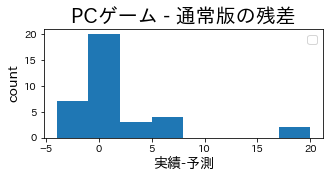

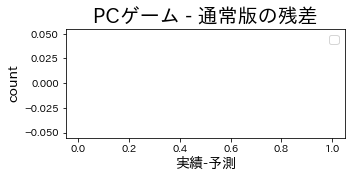

No handles with labels found to put in legend.
No handles with labels found to put in legend.


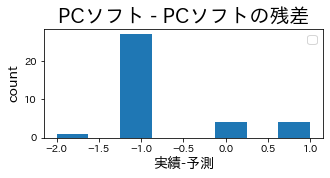

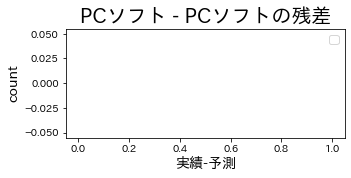

No handles with labels found to put in legend.
No handles with labels found to put in legend.


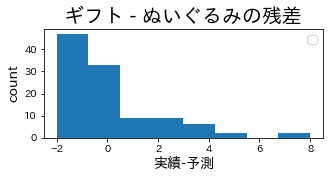

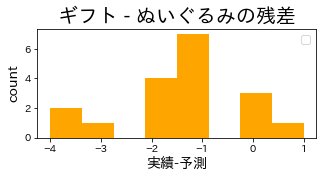

No handles with labels found to put in legend.
No handles with labels found to put in legend.


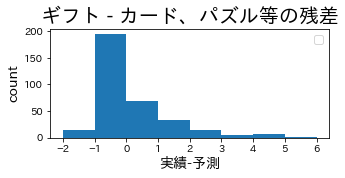

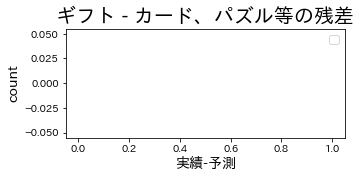

No handles with labels found to put in legend.
No handles with labels found to put in legend.


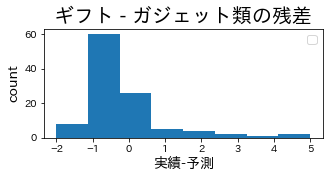

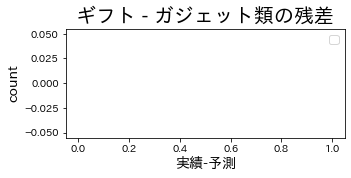

No handles with labels found to put in legend.
No handles with labels found to put in legend.


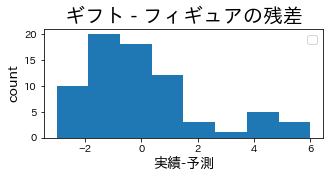

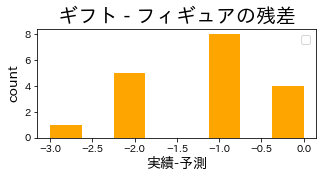

No handles with labels found to put in legend.
No handles with labels found to put in legend.


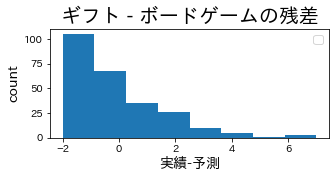

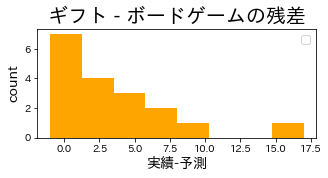

No handles with labels found to put in legend.
No handles with labels found to put in legend.


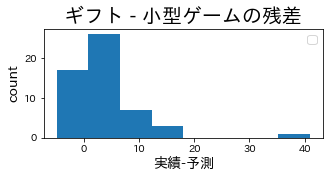

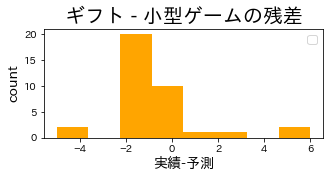

No handles with labels found to put in legend.
No handles with labels found to put in legend.


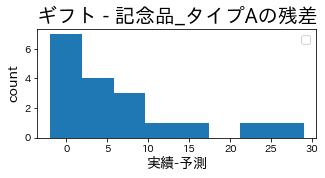

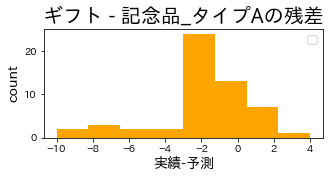

No handles with labels found to put in legend.
No handles with labels found to put in legend.


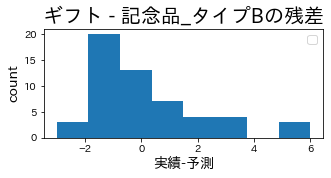

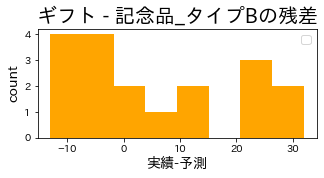

No handles with labels found to put in legend.
No handles with labels found to put in legend.


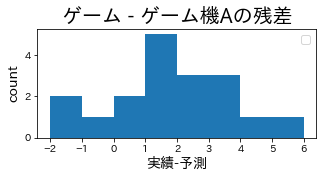

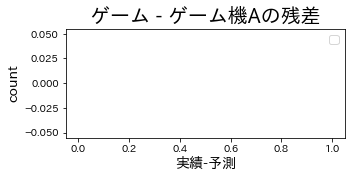

No handles with labels found to put in legend.
No handles with labels found to put in legend.


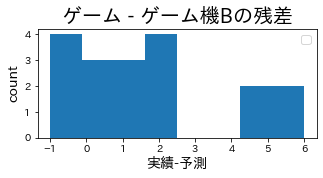

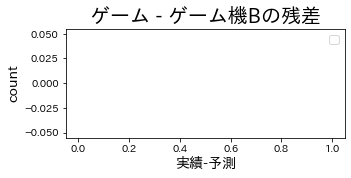

No handles with labels found to put in legend.
No handles with labels found to put in legend.


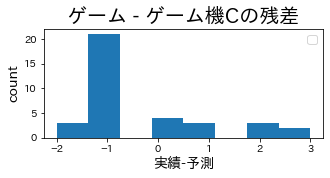

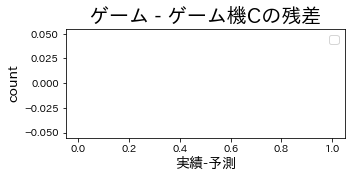

No handles with labels found to put in legend.
No handles with labels found to put in legend.


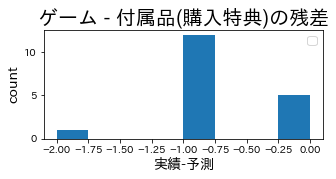

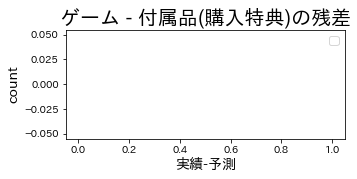

No handles with labels found to put in legend.
No handles with labels found to put in legend.


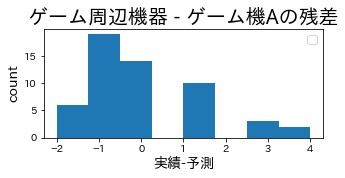

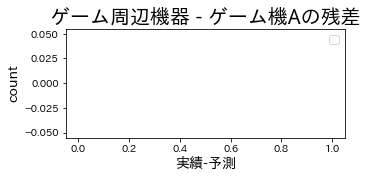

No handles with labels found to put in legend.
No handles with labels found to put in legend.


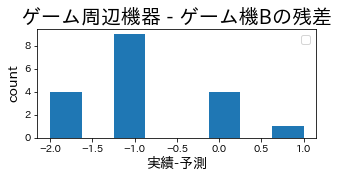

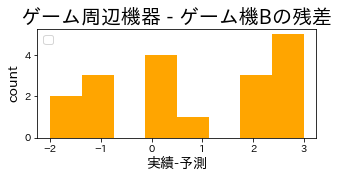

No handles with labels found to put in legend.
No handles with labels found to put in legend.


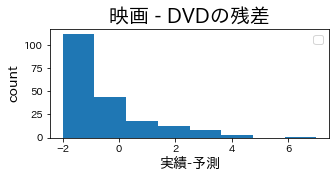

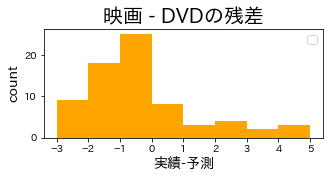

No handles with labels found to put in legend.
No handles with labels found to put in legend.


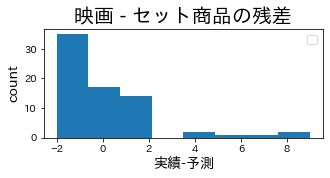

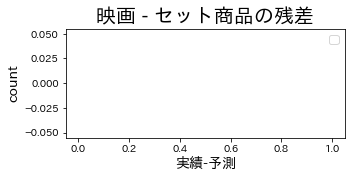

No handles with labels found to put in legend.
No handles with labels found to put in legend.


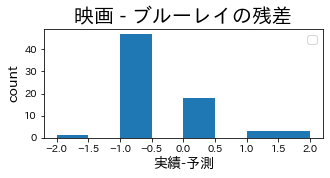

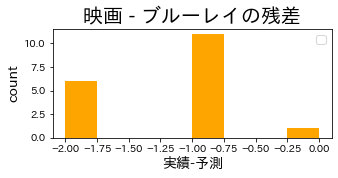

No handles with labels found to put in legend.
No handles with labels found to put in legend.


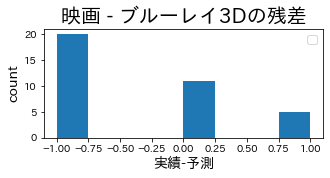

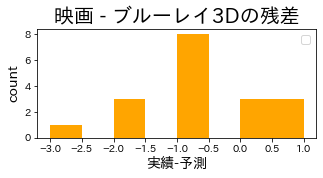

No handles with labels found to put in legend.
No handles with labels found to put in legend.


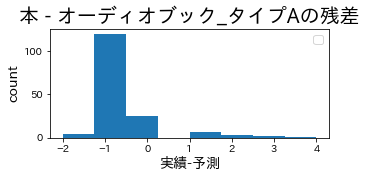

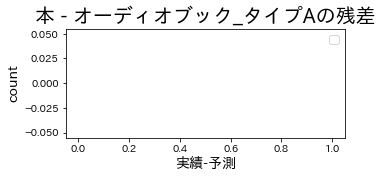

No handles with labels found to put in legend.
No handles with labels found to put in legend.


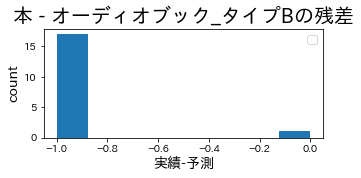

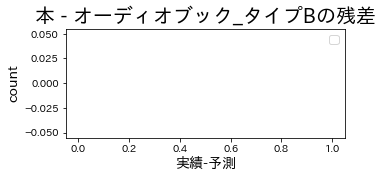

No handles with labels found to put in legend.
No handles with labels found to put in legend.


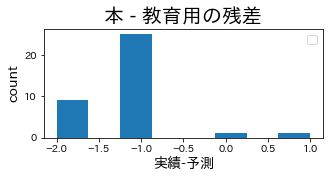

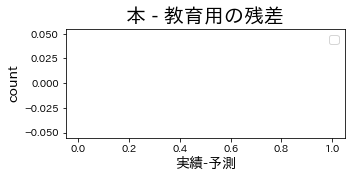

No handles with labels found to put in legend.
No handles with labels found to put in legend.


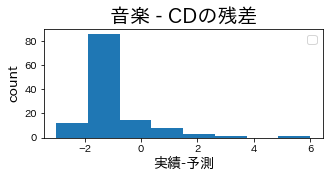

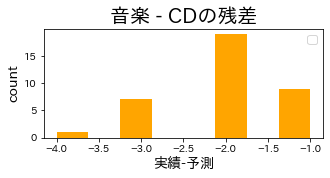

No handles with labels found to put in legend.
No handles with labels found to put in legend.


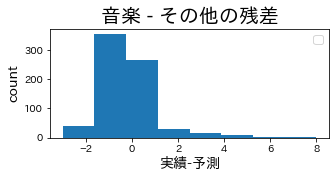

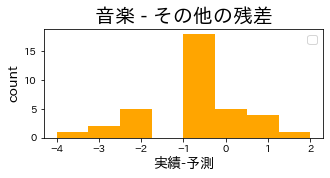

No handles with labels found to put in legend.
No handles with labels found to put in legend.


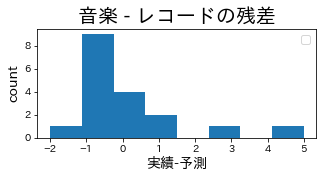

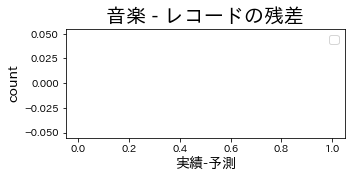

In [78]:
category_list = sorted(analysis_df['商品カテゴリ名'].unique())
for category_nm in category_list:
  tmp_old_df = old_items_df[old_items_df['商品カテゴリ名'] == category_nm]
  tmp_new_df = new_items_df[new_items_df['商品カテゴリ名'] == category_nm]


  plt.figure(figsize = (5, 2), facecolor = 'white')
  tmp_old_df['diff'].hist(bins = 8)
  plt.xlabel('実績-予測', fontsize = 14)
  plt.ylabel('count', fontsize =14)
  plt.title(category_nm + 'の残差', fontsize = 20)
  plt.grid()
  plt.legend(fontsize = 12)

  plt.figure(figsize = (5, 2), facecolor = 'white')
  tmp_new_df['diff'].hist(bins = 8, color = 'orange')
  plt.xlabel('実績-予測', fontsize = 14)
  plt.ylabel('count', fontsize =14)
  plt.title(category_nm + 'の残差', fontsize = 20)
  plt.grid()
  plt.legend(fontsize = 12)
  plt.show()

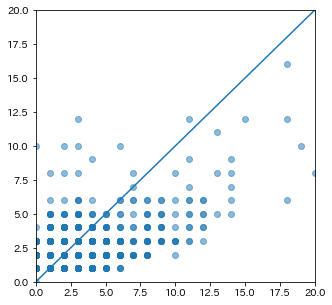

In [79]:
plt.figure(figsize = (5, 5))
plt.scatter(submission_4th_df['real'], submission_4th_df['pred'], alpha = 0.5)
plt.plot([0, 100], [0, 100])
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

In [80]:
print(submission_4th_df['diff'].max())
print(submission_4th_df['diff'].min())

41.0
-13.0


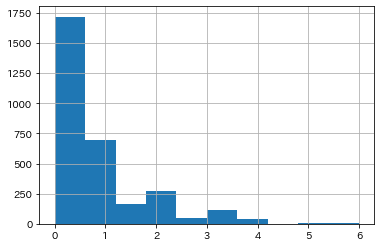

In [81]:
submission_4th_df['per'] = submission_4th_df['real']/submission_4th_df['pred']
submission_4th_df[
  (submission_4th_df['per'] <= 100)
  &(submission_4th_df['per'] >= -100)  
]['per'].hist()

In [82]:
showing_graph_df = analysis_df[
  (analysis_df['diff'] > 10)
  |(analysis_df['diff'] < -10)
]
showing_graph_df.columns.tolist()

['index',
 'pred',
 'real',
 'diff',
 '商品ID',
 '店舗ID',
 '商品カテゴリID',
 '商品カテゴリ名',
 'diff_abs']

In [83]:
showing_graph_df = showing_graph_df[['店舗ID', '商品カテゴリID', '商品カテゴリ名', '商品ID', 'real','pred', 'diff']].sort_values('diff', ascending = False)
showing_graph_df = showing_graph_df.rename(columns = {'real':'売上個数実績値', 'pred':'売上個数予測値', 'diff':'実績-予測'})


print(showing_graph_df.shape)
showing_graph_df.head(100)

(24, 7)


,店舗ID,商品カテゴリID,商品カテゴリ名,商品ID,売上個数実績値,売上個数予測値,実績-予測
1249,7,160,ギフト - 小型ゲーム,1600003,58.0,17,41.0
2865,3,290,ギフト - 記念品_タイプB,2900075,73.0,41,32.0
2879,17,290,ギフト - 記念品_タイプB,2900075,66.0,36,30.0
2739,3,280,ギフト - 記念品_タイプA,2800001,38.0,9,29.0
2743,7,280,ギフト - 記念品_タイプA,2800001,40.0,16,24.0
2872,10,290,ギフト - 記念品_タイプB,2900075,65.0,43,22.0
2862,0,290,ギフト - 記念品_タイプB,2900075,65.0,44,21.0
2873,11,290,ギフト - 記念品_タイプB,2900075,53.0,32,21.0
292,4,110,PCゲーム - 通常版,1100002,27.0,7,20.0
301,13,110,PCゲーム - 通常版,1100002,26.0,7,19.0


# 予測が最も外れた商品の解析

In [84]:
large_df = sales_history[
  (sales_history['商品ID'] == 1600003)
  &(sales_history['店舗ID'] == 7)
]

In [85]:
import datetime as dt
large_df["date"] = pd.to_datetime(large_df["日付"]).dt.strftime("%Y-%m")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
grouped_large_df = large_df.groupby(['date', '店舗ID', '商品ID']).sum().reset_index(drop = False)
grouped_large_df

,date,店舗ID,商品ID,商品価格,売上個数
0,2018-04,7,1600003,8670,20.0
1,2018-05,7,1600003,6580,16.0
2,2018-06,7,1600003,5100,12.0
3,2018-07,7,1600003,6630,13.0
4,2018-08,7,1600003,5100,12.0
5,2018-09,7,1600003,5610,13.0
6,2018-10,7,1600003,7650,20.0
7,2018-11,7,1600003,6120,14.0
8,2018-12,7,1600003,9640,40.0
9,2019-01,7,1600003,8160,20.0


In [87]:
rslt_12 = pd.DataFrame(columns = ['date', '店舗ID', '商品ID', '商品価格', '売上個数'])
rslt_12 = rslt_12.append({'date':'2019-12', '店舗ID':7, '商品ID':1600004, '商品価格':'-', '売上個数':58}, ignore_index = True)
rslt_12['date'] = pd.to_datetime(rslt_12['date'])
rslt_12["date"] = pd.to_datetime(rslt_12["date"]).dt.strftime("%Y-%m")
rslt_12.head()

grouped_large_df = pd.concat([grouped_large_df, rslt_12], axis = 0).reset_index(drop = True)
grouped_large_df

,date,店舗ID,商品ID,商品価格,売上個数
0,2018-04,7,1600003,8670,20
1,2018-05,7,1600003,6580,16
2,2018-06,7,1600003,5100,12
3,2018-07,7,1600003,6630,13
4,2018-08,7,1600003,5100,12
5,2018-09,7,1600003,5610,13
6,2018-10,7,1600003,7650,20
7,2018-11,7,1600003,6120,14
8,2018-12,7,1600003,9640,40
9,2019-01,7,1600003,8160,20


In [88]:
grouped_large_df['pred'] = 17
grouped_large_df.head()

,date,店舗ID,商品ID,商品価格,売上個数,pred
0,2018-04,7,1600003,8670,20,17
1,2018-05,7,1600003,6580,16,17
2,2018-06,7,1600003,5100,12,17
3,2018-07,7,1600003,6630,13,17
4,2018-08,7,1600003,5100,12,17


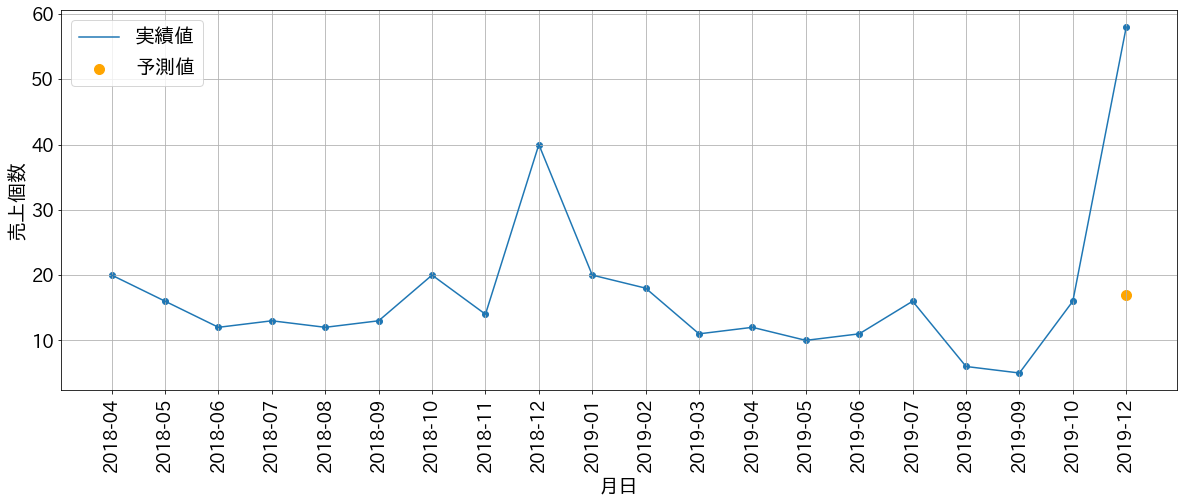

In [89]:
plt.figure(figsize = (20, 7), facecolor = 'white')
plt.plot(grouped_large_df['date'], grouped_large_df['売上個数'], label = '実績値')
plt.scatter(grouped_large_df['date'], grouped_large_df['売上個数'])
plt.scatter(grouped_large_df.tail(1)['date'], grouped_large_df.tail(1)['pred'],color = 'orange', s=100, label = '予測値')
plt.xlabel('月日', fontsize = 20)
plt.ylabel('売上個数', fontsize = 20)
plt.xticks(fontsize = 18, rotation = 90)
plt.yticks(fontsize = 18)
plt.grid()
plt.legend(fontsize = 20)
plt.show()

# 平均商品価格

In [90]:
sales_history.head()

,日付,店舗ID,商品ID,商品価格,売上個数
0,2018-01-01,9,1000001,420,1.0
1,2018-01-01,6,1000001,420,1.0
2,2018-01-01,10,1000001,420,1.0
3,2018-01-01,0,1000017,250,1.0
4,2018-01-01,1,1000017,250,1.0


In [91]:
grouped_sales_history = sales_history.groupby('商品ID').mean().reset_index(drop = False)

In [92]:
grouped_sales_history['商品価格'].mean()

1060.9187014541224

In [93]:
sales_history['商品価格'].mean()

1049.4254758523361